# Evolution strategies on test functions for optimization

## Test functions for optimization

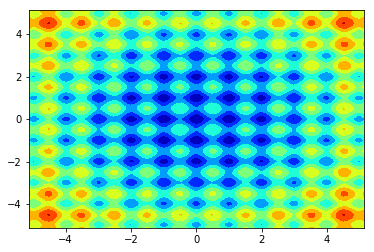

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from lagom.es import rastrigin
from lagom.es import sphere
from lagom.es import styblinski_tang
from lagom.es import holder_table


x = np.linspace(-5.12, 5.12, num=100)
y = np.linspace(-5.12, 5.12, num=100)
x, y = np.meshgrid(x, y)

z = rastrigin([x, y])

fig, ax = plt.subplots(1, 1)
ax.contourf(x, y, z, cmap='jet')

In [3]:
from lagom.utils import set_global_seeds

set_global_seeds(0)

def make_cma_es():
    es = CMAES(mu0=[3]*100, 
               std0=0.5, 
               popsize=12)
    
    return es

def make_openai_es(antithetic, rank_transform):
    es = OpenAIES(mu0=[3]*100, 
                  std0=0.5, 
                  popsize=64, 
                  std_decay=0.999,
                  min_std=0.01, 
                  lr=1e-1, 
                  lr_decay=1.0, 
                  min_lr=1e-1, 
                  antithetic=antithetic, 
                  rank_transform=rank_transform)
    
    return es

In [8]:
from lagom.utils import timed

from cma_es import CMAES
from openai_es import OpenAIES

from lagom.es import BaseESWorker
from lagom.es import BaseESMaster


class ESWorker(BaseESWorker):
    def prepare(self):
        pass
        
    def f(self, config, solution):
        function_value = rastrigin(solution)
        
        return function_value
    

class ESMaster(BaseESMaster):
    def make_es(self, config):
        es = make_openai_es(True, True)
        self.f_values = []
        
        return es
        
    def process_es_result(self, result):
        best_f_val = result['best_f_val']
        if self.generation == 0 or (self.generation+1) % 500 == 0:
            self.f_values.append(best_f_val)
            print(f'Best function value at generation {self.generation+1}: {best_f_val}')
            

with timed():
    config = {'train.num_iteration': 5000}
    es = ESMaster(config, ESWorker)
    es()

Best function value at generation 1: 1728.606939555127
Best function value at generation 500: 876.4832143339644
Best function value at generation 1000: 714.025019726093
Best function value at generation 1500: 531.592586111021
Best function value at generation 2000: 579.1919998933784
Best function value at generation 2500: 488.70818012654325
Best function value at generation 3000: 499.59742540548723
Best function value at generation 3500: 498.1553594622914
Best function value at generation 4000: 472.1536723312375
Best function value at generation 4500: 344.99721358423346
Best function value at generation 5000: 355.56430171547373

Total time: 0:00:17


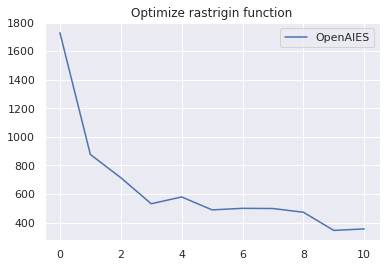

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(es.f_values, label='OpenAIES')

ax.set_title('Optimize rastrigin function')
ax.legend()